<a href="https://colab.research.google.com/github/ozlemakboyraz/Brain-Classification-Project/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc as sklearn_auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, models, transforms

# 1. GPU (CUDA) Otomatik Algılama
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

Kullanılan Cihaz: cuda


In [48]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
!cp "/content/drive/MyDrive/brain-dataset/Dataset_224x224.rar" /content/
!unrar x /content/Dataset_224x224.rar /content/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0713.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0714.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0715.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0716.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0717.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0718.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0719.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0720.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0721.jpg       26%  OK 
Extracting  /content/Dataset_224x224/Training/glioma/Tr-gl_0722.jpg       26%  OK 
Extracting  /content/Dataset_224x

In [50]:
# 2. Veri Yolları ve Hiperparametreler
DATA_DIR = '/content//Dataset_224x224'
TRAIN_DIR = os.path.join(DATA_DIR, 'Training')
TEST_DIR = os.path.join(DATA_DIR, 'Testing')

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS_PER_FOLD = 10

In [51]:
# 3. MRI Görüntüleri İçin Data Augmentation ve Normalizasyon
# ImageNet istatistikleri transfer learning için standarttır.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Validation ve Test setlerinde sadece resize ve normalize uygulanır
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [52]:
# 4. EfficientNetB0 Model Yapılandırması
def get_efficientnet_model():
    # Pretrained EfficientNetB0 yükleme
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    # Kademeli Fine-Tuning Stratejisi
    # EfficientNetB0 yaklaşık 7 ana bloktan oluşur.
    # İlk 3 bloğu dondurmak yaklaşık %40 katman dondurmaya tekabül eder.
    all_layers = list(model.features.children())
    num_layers = len(all_layers)
    freeze_until = int(num_layers * 0.4)

    for i, layer in enumerate(all_layers):
        if i < freeze_until:
            for param in layer.parameters():
                param.requires_grad = False
        else:
            for param in layer.parameters():
                param.requires_grad = True

    # Çıkış katmanını (Classifier) 4 sınıflı olacak şekilde yeniden tanımlama
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)

    return model.to(device)

In [53]:
# 5. Dataset Sınıfı
class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root_dir)
        self.transform = transform
        self.classes = self.dataset.classes

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)


In [54]:
# 6. 5-Fold Stratified Cross-Validation ve Eğitim
full_train_dataset = BrainMRIDataset(TRAIN_DIR)
labels = [sample[1] for sample in full_train_dataset.dataset.samples]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_histories = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
    print(f"\n--- FOLD {fold+1} / 5 ---")

    train_sub = Subset(full_train_dataset, train_idx)
    val_sub = Subset(full_train_dataset, val_idx)

    # Dinamik transform atama
    train_sub.dataset.transform = train_transforms
    val_sub.dataset.transform = val_test_transforms

    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False)

    model = get_efficientnet_model()

    # Differential Learning Rate Tanımlama
    # EfficientNet blok yapısına göre gruplandırma:
    optimizer = optim.Adam([
        {'params': model.features[3:5].parameters(), 'lr': 1e-5}, # Orta katmanlar (layer2 benzeri)
        {'params': model.features[5:7].parameters(), 'lr': 5e-5}, # Daha üst katmanlar (layer3 benzeri)
        {'params': model.features[7:].parameters(), 'lr': 1e-4},  # En üst katmanlar (layer4 benzeri)
        {'params': model.classifier.parameters(), 'lr': 1e-3}    # Fully connected
    ])

    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(EPOCHS_PER_FOLD):
        # Training Phase
        model.train()
        running_loss, running_corrects = 0.0, 0
        for inputs, labels_batch in train_loader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels_batch)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels_batch.data)

        train_epoch_loss = running_loss / len(train_idx)
        train_epoch_acc = running_corrects.double() / len(train_idx)

        # Validation Phase
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels_batch in val_loader:
                inputs, labels_batch = inputs.to(device), labels_batch.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels_batch)
                _, preds = torch.max(outputs, 1)
                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels_batch.data)

        val_epoch_loss = val_running_loss / len(val_idx)
        val_epoch_acc = val_running_corrects.double() / len(val_idx)

        history['train_loss'].append(train_epoch_loss)
        history['train_acc'].append(train_epoch_acc.cpu().item())
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc.cpu().item())

        print(f"Epoch {epoch+1}/{EPOCHS_PER_FOLD} - Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f} | Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")

    fold_histories.append(history)



--- FOLD 1 / 5 ---
Epoch 1/10 - Train Loss: 0.4029 Acc: 0.8661 | Val Loss: 0.1822 Acc: 0.9291
Epoch 2/10 - Train Loss: 0.1337 Acc: 0.9518 | Val Loss: 0.1029 Acc: 0.9615
Epoch 3/10 - Train Loss: 0.0788 Acc: 0.9748 | Val Loss: 0.0769 Acc: 0.9711
Epoch 4/10 - Train Loss: 0.0509 Acc: 0.9827 | Val Loss: 0.0764 Acc: 0.9711
Epoch 5/10 - Train Loss: 0.0364 Acc: 0.9873 | Val Loss: 0.0672 Acc: 0.9729
Epoch 6/10 - Train Loss: 0.0281 Acc: 0.9904 | Val Loss: 0.0634 Acc: 0.9799
Epoch 7/10 - Train Loss: 0.0234 Acc: 0.9928 | Val Loss: 0.0489 Acc: 0.9843
Epoch 8/10 - Train Loss: 0.0179 Acc: 0.9947 | Val Loss: 0.0644 Acc: 0.9799
Epoch 9/10 - Train Loss: 0.0182 Acc: 0.9943 | Val Loss: 0.0526 Acc: 0.9825
Epoch 10/10 - Train Loss: 0.0091 Acc: 0.9982 | Val Loss: 0.0458 Acc: 0.9843

--- FOLD 2 / 5 ---
Epoch 1/10 - Train Loss: 0.3990 Acc: 0.8658 | Val Loss: 0.1464 Acc: 0.9466
Epoch 2/10 - Train Loss: 0.1449 Acc: 0.9494 | Val Loss: 0.0945 Acc: 0.9606
Epoch 3/10 - Train Loss: 0.0792 Acc: 0.9726 | Val Loss: 0.0

In [55]:
# 7. Final Test Değerlendirmesi
print("\n--- TEST SETİ ÜZERİNDE FİNAL DEĞERLENDİRME ---")
test_dataset = BrainMRIDataset(TEST_DIR, transform=val_test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_preds, all_labels, all_probs = [], [], []

model.eval()
with torch.no_grad():
    for inputs, labels_batch in test_loader:
        inputs, labels_batch = inputs.to(device), labels_batch.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels_batch.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Metriklerin Hesaplanması
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

print(f"\nSayısal Test Sonuçları:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")


--- TEST SETİ ÜZERİNDE FİNAL DEĞERLENDİRME ---

Sayısal Test Sonuçları:
Accuracy:  0.9878
Precision: 0.9879
Recall:    0.9878
F1-Score:  0.9878
ROC-AUC:   0.9996


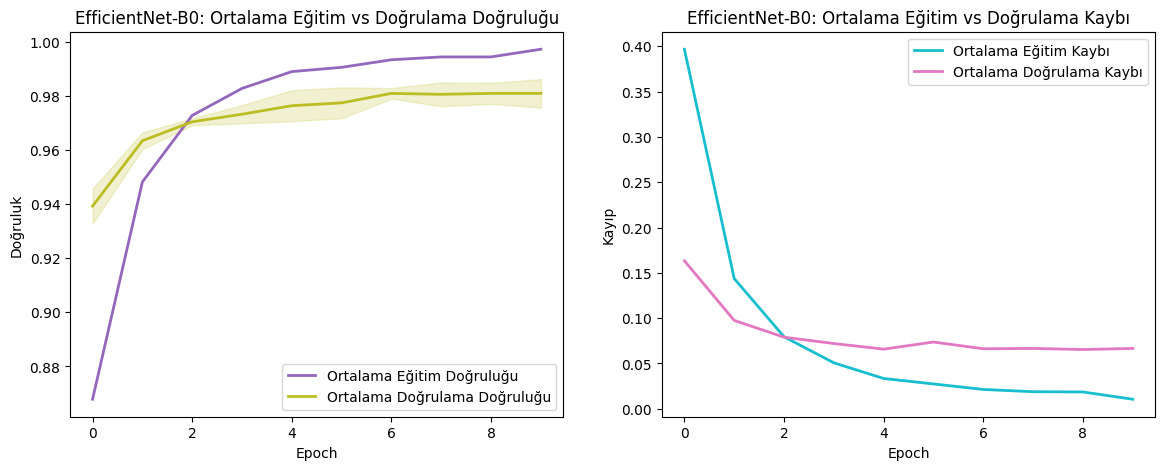

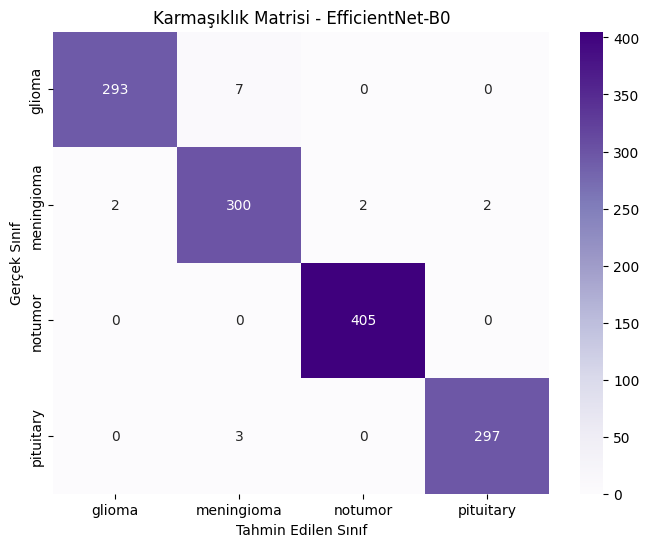

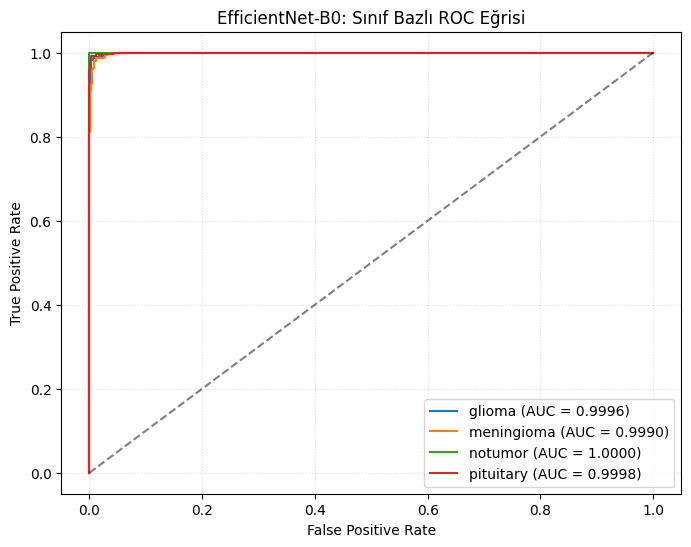

In [56]:
# 8. GRAFİKLER

# --- A. Ortalama Accuracy ve Loss Grafikleri (5-Fold Mean) ---
# Eğitim kodundaki 'fold_histories' listesini kullanıyoruz
epochs = range(len(fold_histories[0]['train_acc']))
train_accs = np.array([h['train_acc'] for h in fold_histories])
val_accs = np.array([h['val_acc'] for h in fold_histories])
train_losses = np.array([h['train_loss'] for h in fold_histories])
val_losses = np.array([h['val_loss'] for h in fold_histories])

plt.figure(figsize=(14, 5))

# Ortalama Accuracy ve Standart Sapma
plt.subplot(1, 2, 1)
plt.plot(epochs, np.mean(train_accs, axis=0), label='Ortalama Eğitim Doğruluğu', color='#9467bd', lw=2)
plt.plot(epochs, np.mean(val_accs, axis=0), label='Ortalama Doğrulama Doğruluğu', color='#bcbd22', lw=2)
plt.fill_between(epochs, np.mean(val_accs, axis=0) - np.std(val_accs, axis=0),
                 np.mean(val_accs, axis=0) + np.std(val_accs, axis=0), color='#bcbd22', alpha=0.2)
plt.title('EfficientNet-B0: Ortalama Eğitim vs Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Ortalama Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, np.mean(train_losses, axis=0), label='Ortalama Eğitim Kaybı', color='#17becf', lw=2)
plt.plot(epochs, np.mean(val_losses, axis=0), label='Ortalama Doğrulama Kaybı', color='#e377c2', lw=2)
plt.title('EfficientNet-B0: Ortalama Eğitim vs Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.show()

# --- B. Karmaşıklık Matrisi ---
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Purples',
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Karmaşıklık Matrisi - EfficientNet-B0')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

# --- C. Sınıf Bazlı ROC Eğrisi ---
plt.figure(figsize=(8, 6))
all_labels_np = np.array(all_labels)
all_probs_np = np.array(all_probs)

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(all_labels_np == i, all_probs_np[:, i])
    # Hata veren 'auc' yerine 'sklearn_auc' kullandık
    class_auc = sklearn_auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{test_dataset.classes[i]} (AUC = {class_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.title('EfficientNet-B0: Sınıf Bazlı ROC Eğrisi')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.4)
plt.show()